# Notebook used for testing functions developed in the iib-neuro-proj library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *

### Generate some 'realisitc' inputs

[ 0.  0. 15. 14. 14.  0. 15.  1. 15. 14. 15.  0. 15. 15.  2.  0.]
orientation 0 finished
orientation 1 finished
orientation 2 finished
orientation 3 finished
orientation 4 finished
orientation 5 finished
orientation 6 finished
orientation 7 finished
orientation 8 finished
orientation 9 finished
orientation 10 finished
orientation 11 finished
orientation 12 finished
orientation 13 finished
orientation 14 finished
orientation 15 finished
Excitatory spikes shape: (187919, 2) Inhibitory spikes shape: (546841, 2)


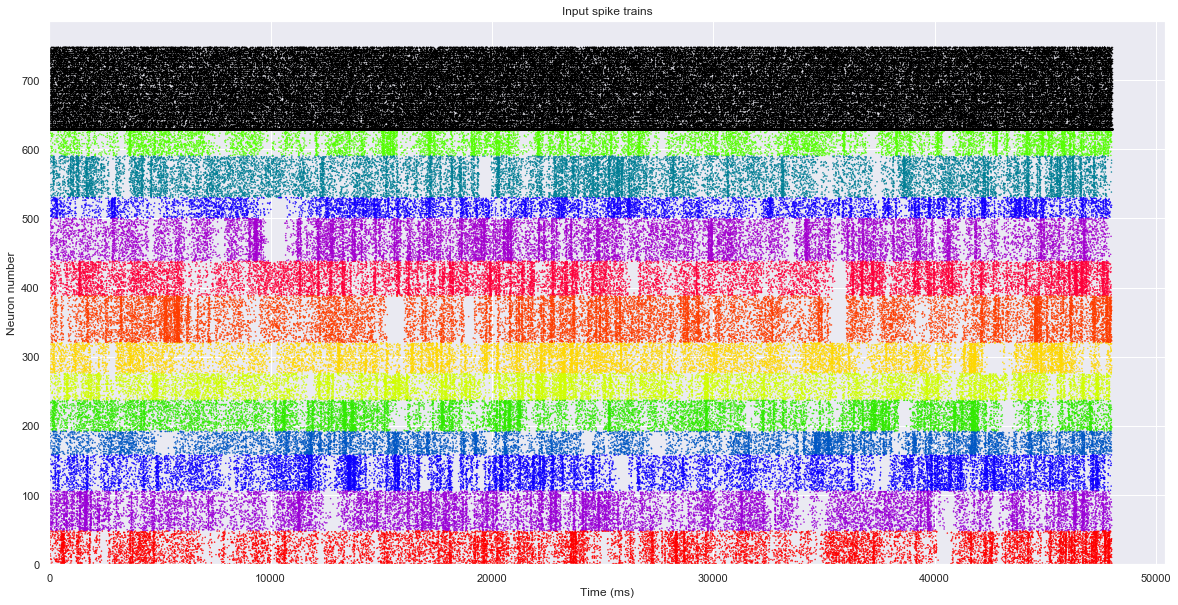

In [2]:
E_spikes, I_spikes = gen_realistic_inputs(Tmax=3000)
print("Excitatory spikes shape:", E_spikes.shape, "Inhibitory spikes shape:", I_spikes.shape)

Ensyn = [48, 58, 52, 34, 45, 39, 44, 68, 50, 62, 30, 60, 39]
Ensyn_cum = np.cumsum(Ensyn)
Ensyn_cum = Ensyn_cum.reshape(13, 1)
ens_num = np.argmax(Ensyn_cum > E_spikes[:, 0] - 1, axis=0)

plt.figure(figsize=(20,10))
plt.scatter(E_spikes[:, 1], E_spikes[:, 0], s=1, c=ens_num, cmap="prism", marker='.', label="Excitatory")
plt.scatter(I_spikes[:, 1], np.sum(Ensyn) + I_spikes[:, 0], s=1, marker='.', color='black', label='Inhibitory')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron number")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.title("Input spike trains")
plt.show()

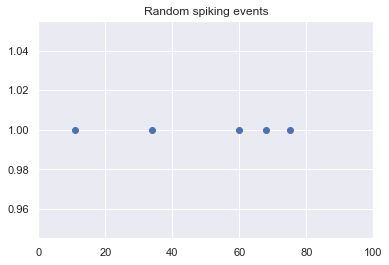

In [3]:
N = 100 # number of time bins
samp = binary_input(1, N, kind='rand')
times = np.arange(0, N, 1)
spikes = np.where(samp==0, np.nan, samp)
plt.plot(times, spikes.T, 'o')
plt.title("Random spiking events")
plt.xlim(0, N)
plt.show()

(1, 100)


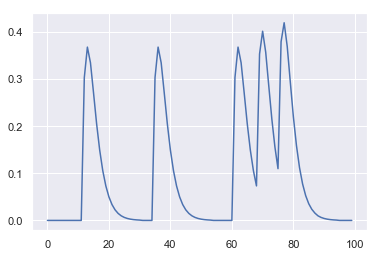

In [4]:
# show alpha filt works
conv = alpha_filt(tau=2, spikes=samp)
print(conv.shape)
plt.plot(times, conv.T)
plt.show()

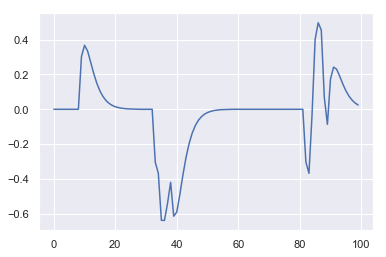

(100,)


In [5]:
# show int_spikes works
samp_2d = binary_input(2, N, kind='rand')
conv_int = int_spikes(X=samp_2d, dt=1, Wc=[0, 1], Ww=[1, -1], Tau=2, delay=0)
plt.plot(times, conv_int.T)
plt.show()
print(conv_int.shape)

No handles with labels found to put in legend.


[1.]


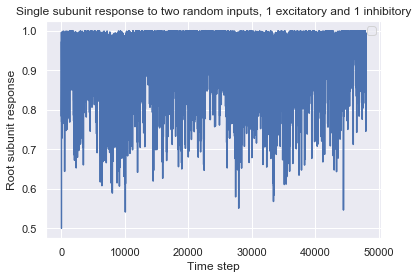

In [6]:
# input realistic inputs to model
X_e = spikes_to_input(E_spikes, Tmax=48000)
X_i = spikes_to_input(I_spikes, Tmax=48000)

# these parameters for 1 subunit
Jc_sing = np.array([0])
M = len(Jc_sing) #number of subunits
Wce_sing = [np.arange(0, X_e.shape[0], 1)] #all input neurons connected to root subunit
Wwe_sing = [np.ones(X_e.shape[0])] #weighting matrix - all neurons connected with weight 1 initially
Tau_e = [np.full(X_e.shape[0], 1)] #all excitatory time constants 1
Th = [[0]] #no offset in all sigmoids

# print(Wwe_sing[0])


resp_sing = sim_hLN(X=X_e, dt=1, Jc=Jc_sing, Wce=Wce_sing, Wwe=Wwe_sing, Wci=[[0]], Wwi=[[0]], Tau_e=Tau_e, Tau_i=[], Th=Th, mult_inputs=True)

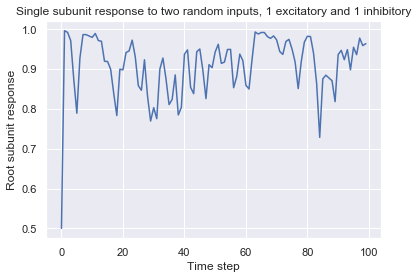

In [8]:
plt.plot(resp_sing[:100])
plt.title("Single subunit response to two random inputs, 1 excitatory and 1 inhibitory")
plt.xlabel("Time step")
plt.ylabel("Root subunit response")
plt.show()